In [1116]:
import yfinance as yf
import pandas as pd
import numpy as np
import talib
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_selection import VarianceThreshold

import datetime
import matplotlib.pyplot as plt
import seaborn as sns


In [1117]:
def get_data():
    # Download S&P 500 (GSPC) and VIX data
    start = '1990-01-01'
    sp500 = yf.download('^GSPC', start=start, end=datetime.datetime.today().strftime('%Y-%m-%d'))
    vix = yf.download('^VIX', start=start, end=datetime.datetime.today().strftime('%Y-%m-%d'))
    
    # Fetch 10-year Treasury Yield from FRED
    treasury_yield = yf.download("^TNX", start=start, end=datetime.datetime.today().strftime('%Y-%m-%d'))
    
    # Merge dataframes
    df = sp500[['Open', 'High', 'Low', 'Close', 'Volume']]
    df['VIX'] = vix['Close']
    df['10Y_Treasury'] = treasury_yield['Close']
    
    return df

In [1118]:
def add_technical_indicators(df):
    df['Return'] = df['Close'].pct_change()
    df['Return_neg'] = np.where(df['Return'] < -0.01, 0.1, 0.0)
    df['Return_pos'] = np.where(df['Return'] < 0.01, 0.0, 1.0)
    df['Return_Yesterday'] = df['Return'].shift(1)
    df['VIX_CHANGE'] = df['VIX'].pct_change()
    df['Volume_CHANGE'] = df['Volume'].pct_change()
    df['VIX_5'] = talib.SMA(df['VIX_CHANGE'].values.flatten(), timeperiod=5)
    df['VIX_10'] = talib.SMA(df['VIX_CHANGE'].values.flatten(), timeperiod=10)
    df['VIX_50'] = talib.SMA(df['VIX_CHANGE'].values.flatten(), timeperiod=50)
    df['10Y_CHANGE'] = df['10Y_Treasury'].pct_change()
    df['SMA_5_neg'] = talib.SMA(df['Return_neg'].values.flatten(), timeperiod=5)
    df['SMA_5_pos'] = talib.SMA(df['Return_pos'].values.flatten(), timeperiod=5)
    df['rolling_sum_5'] = df['Return'].rolling(window=5).sum()
    df['SMA_5'] = talib.SMA(df['Return'].values.flatten(), timeperiod=5)
    df['SMA_10'] = talib.SMA(df['Return'].values.flatten(), timeperiod=10)
    df['SMA_10_neg'] = talib.SMA(df['Return_neg'].values.flatten(), timeperiod=10)
    df['SMA_10_pos'] = talib.SMA(df['Return_pos'].values.flatten(), timeperiod=10)
    df['SMA_50'] = talib.SMA(df['Return'].values.flatten(), timeperiod=50)
    df['RSI'] = talib.RSI(df['Return'].values.flatten(), timeperiod=14)
    df['MACD'], df['MACD_signal'], _ = talib.MACD(df['Close'].values.flatten())
    df['MACD_zscore'] = (df['MACD'] - df['MACD'].mean()) / df['MACD'].std()
    df['ATR'] = talib.ATR(df['High'].values.flatten(), df['Low'].values.flatten(), df['Close'].values.flatten(), timeperiod=14)
    
    return df

In [1119]:
def prepare_dataset(df):
    df['Target'] = np.where(df['Return'].shift(-1) < 0.0075, 0, 1)  # Predicting if next day is up (1) or down (0)
    
    # Drop NaNs
    df.dropna(inplace=True)
    
    # Select features
    features = ['Return', 'Return_neg', 'Return_pos', '10Y_Treasury', 'Volume_CHANGE', 'SMA_5_neg', 'SMA_5_pos', 'SMA_50', 'VIX', 'VIX_5', 'VIX_10', 'ATR', 'MACD', 'RSI']
    X = df[features]
    y = df['Target']
    
    return X, y

In [1120]:
def train_and_evaluate_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    # Define models
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Logistic Regression": LogisticRegression(),
        "Gradient Boosting (XGBoost)": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
        "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
    }

    best_model = None
    best_accuracy = 0

    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{name} Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.5f}")
        print(f"Recall: {recall_score(y_test, y_pred):.5f}")
        print(f"F1 Score: {f1_score(y_test, y_pred):.5f}")
        predict_next_day(model, X)

        if accuracy > best_accuracy:
            best_model = model
            best_accuracy = accuracy

    return best_model

In [1121]:
def train_model(X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Logistic Regression": LogisticRegression(),
        "Gradient Boosting (XGBoost)": GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, random_state=42),
        "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', max_iter=500, random_state=42)
    }
    best_model = None
    best_accuracy = 0

    for name, model in models.items():
        accuracies = []
        precisions = []
        recalls = []
        f1s = []
        print(f"\nTraining {name} with Time-Series Cross Validation...")
        
        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            accuracies.append(acc)
            precisions.append(precision_score(y_test, y_pred, zero_division=0))
            recalls.append(recall_score(y_test, y_pred))
            f1s.append(f1_score(y_test, y_pred))
        
        avg_accuracy = np.mean(accuracies)
        print(accuracies)
        print(f"{name} Average Accuracy: {avg_accuracy:.4f}")
        print(f"Precision: {np.mean(precisions):.5f}")
        print(f"Recall: {np.mean(recalls):.5f}")
        print(f"F1 Score: {np.mean(f1s):.5f}")
        
        predict_next_day(model, X)
        
        if avg_accuracy > best_accuracy:
            best_model = model
            best_accuracy = avg_accuracy

    return best_model

In [1122]:
def predict_next_day(model, X):
    latest_data = X.iloc[-1].values.reshape(1, -1) 
    prediction = model.predict(latest_data)
    y_pred = model.predict(X)
    average_pred = sum(y_pred) / len(y_pred)
    print(f"average prediction: {average_pred}")

    #print(f"Accuracy: {accuracy:.2f}")

    for i in range(-5, 0, 1):
        print(f"Prediction: S&P 500 on {str(X.iloc[i].name.date())} will go {english_result(prediction[0])}.")


In [1123]:
def english_result(guess):
    if guess == 1:
        return 'UP'
    else:
        return 'DOWN'

In [1124]:
print("Downloading data...")
df = get_data()
    
print("Adding technical indicators...")
df = add_technical_indicators(df)
    
print("Preparing dataset...")
X, y = prepare_dataset(df)
    
print("Training model groups...")
model_split = train_model(X, y)

print("Train classic")
model_classic = train_and_evaluate_models(X, y)

average_y = sum(y) / len(y)
print(f"Actual average {average_y}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Adding technical indicators...



<ipython-input-1117-bc9c18445be5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['VIX'] = vix['Close']
<ipython-input-1117-bc9c18445be5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['10Y_Treasury'] = treasury_yield['Close']
<ipython-input-1118-3275ab726bcc>:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA 

Preparing dataset...
Training model groups...

Training Random Forest with Time-Series Cross Validation...
[0.7435020519835841, 0.8180574555403557, 0.7359781121751026, 0.8508891928864569, 0.7626538987688098]
Random Forest Average Accuracy: 0.7822
Precision: 0.41516
Recall: 0.12081
F1 Score: 0.17220
average prediction: 0.16839466788196422
Prediction: S&P 500 on 2025-02-25 will go DOWN.
Prediction: S&P 500 on 2025-02-26 will go DOWN.
Prediction: S&P 500 on 2025-02-27 will go DOWN.
Prediction: S&P 500 on 2025-02-28 will go DOWN.
Prediction: S&P 500 on 2025-03-03 will go DOWN.

Training Logistic Regression with Time-Series Cross Validation...


/Users/bkanouse/.pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bkanouse/.pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

[0.7373461012311902, 0.8194254445964432, 0.7510259917920656, 0.8549931600547196, 0.7503419972640218]
Logistic Regression Average Accuracy: 0.7826
Precision: 0.46416
Recall: 0.10274
F1 Score: 0.15242
average prediction: 0.028711404808020966
Prediction: S&P 500 on 2025-02-25 will go DOWN.
Prediction: S&P 500 on 2025-02-26 will go DOWN.
Prediction: S&P 500 on 2025-02-27 will go DOWN.
Prediction: S&P 500 on 2025-02-28 will go DOWN.
Prediction: S&P 500 on 2025-03-03 will go DOWN.

Training Gradient Boosting (XGBoost) with Time-Series Cross Validation...
[0.7462380300957593, 0.8180574555403557, 0.7366621067031464, 0.8556771545827634, 0.7660738714090287]
Gradient Boosting (XGBoost) Average Accuracy: 0.7845
Precision: 0.45693
Recall: 0.09239
F1 Score: 0.13661
average prediction: 0.014355702404010483
Prediction: S&P 500 on 2025-02-25 will go DOWN.
Prediction: S&P 500 on 2025-02-26 will go DOWN.
Prediction: S&P 500 on 2025-02-27 will go DOWN.
Prediction: S&P 500 on 2025-02-28 will go DOWN.
Predi

/Users/bkanouse/.pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Gradient Boosting (XGBoost) Accuracy: 0.7927
Precision: 0.57143
Recall: 0.03270
F1 Score: 0.06186
average prediction: 0.016406517033154835
Prediction: S&P 500 on 2025-02-25 will go DOWN.
Prediction: S&P 500 on 2025-02-26 will go DOWN.
Prediction: S&P 500 on 2025-02-27 will go DOWN.
Prediction: S&P 500 on 2025-02-28 will go DOWN.
Prediction: S&P 500 on 2025-03-03 will go DOWN.

Training Neural Network (MLP)...
Neural Network (MLP) Accuracy: 0.7876
Precision: 0.41176
Recall: 0.03815
F1 Score: 0.06983
average prediction: 0.02187535604420645
Prediction: S&P 500 on 2025-02-25 will go DOWN.
Prediction: S&P 500 on 2025-02-26 will go DOWN.
Prediction: S&P 500 on 2025-02-27 will go DOWN.
Prediction: S&P 500 on 2025-02-28 will go DOWN.
Prediction: S&P 500 on 2025-03-03 will go DOWN.
Actual average 0.19402985074626866


<AxesSubplot:xlabel='Price-Ticker', ylabel='Price-Ticker'>

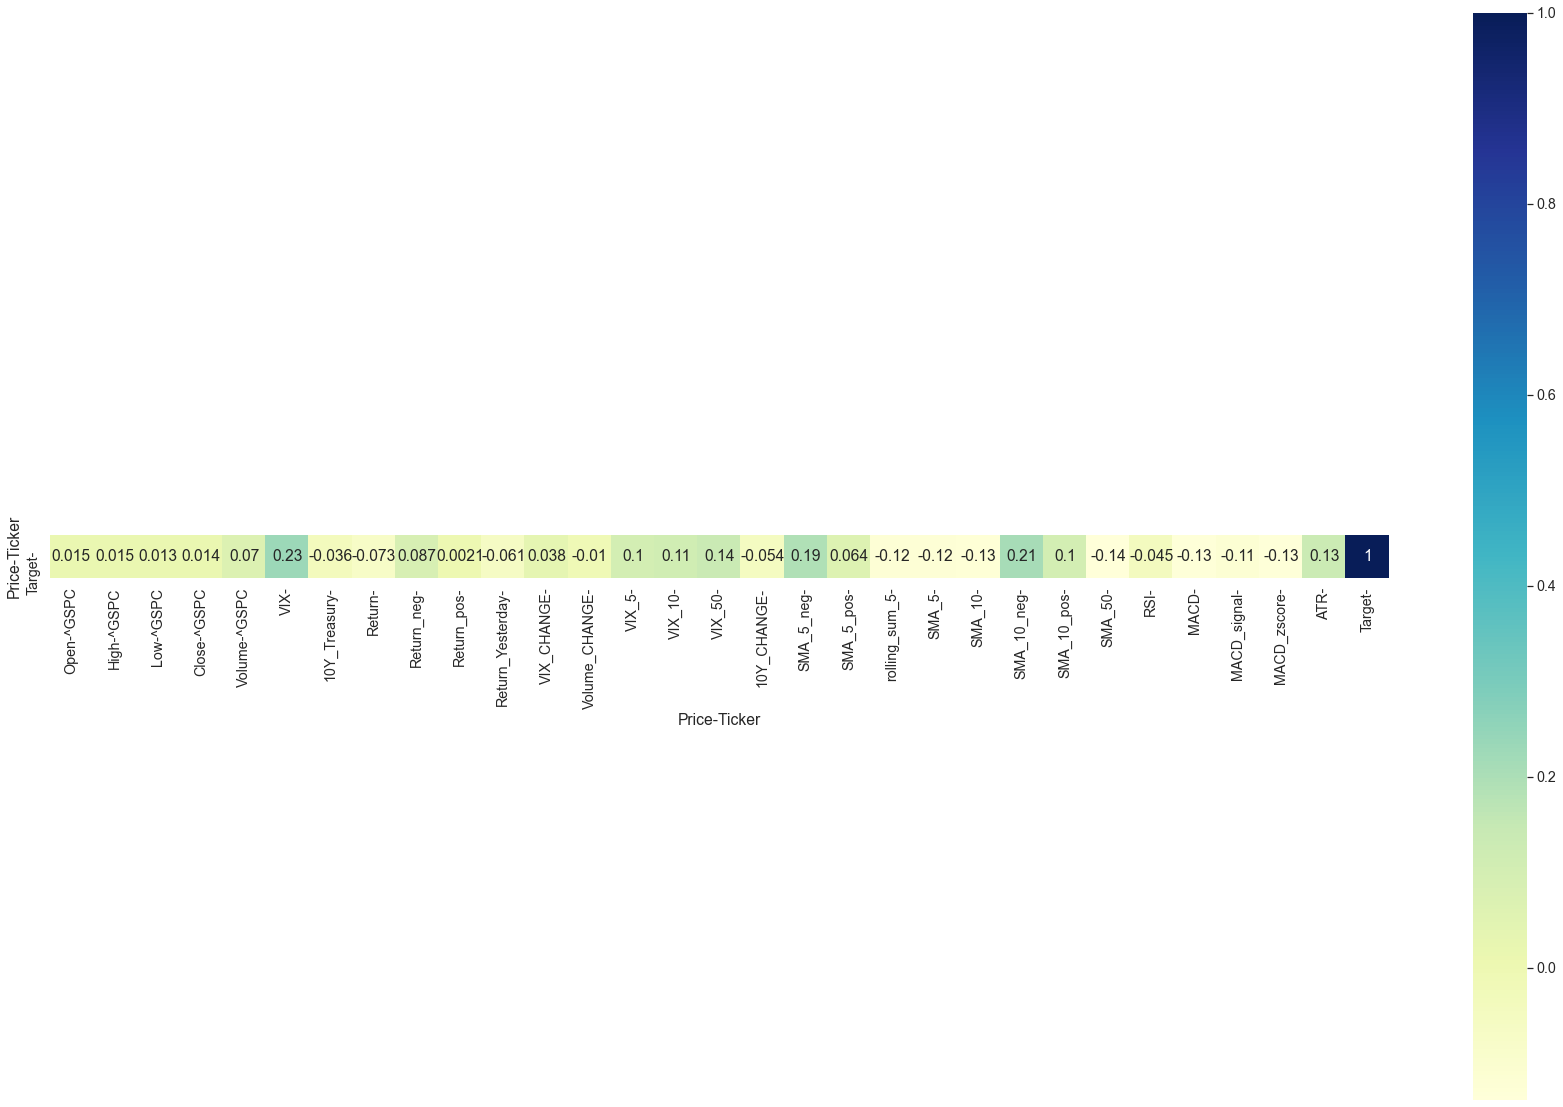

In [1125]:
corr_mat = df.corr(method='pearson')
plt.figure(figsize=(30,20))
sns.set(font_scale=1.3)
sns.heatmap(corr_mat[['Target']].transpose(), vmax=1, square=True, annot=True, cmap="YlGnBu")

In [1126]:
y.iloc[-32]

0

In [1127]:
y_pred = model_split.predict(X)
precision = precision_score(y, y_pred, zero_division=0)

<AxesSubplot:xlabel='Price-Ticker', ylabel='Price-Ticker'>

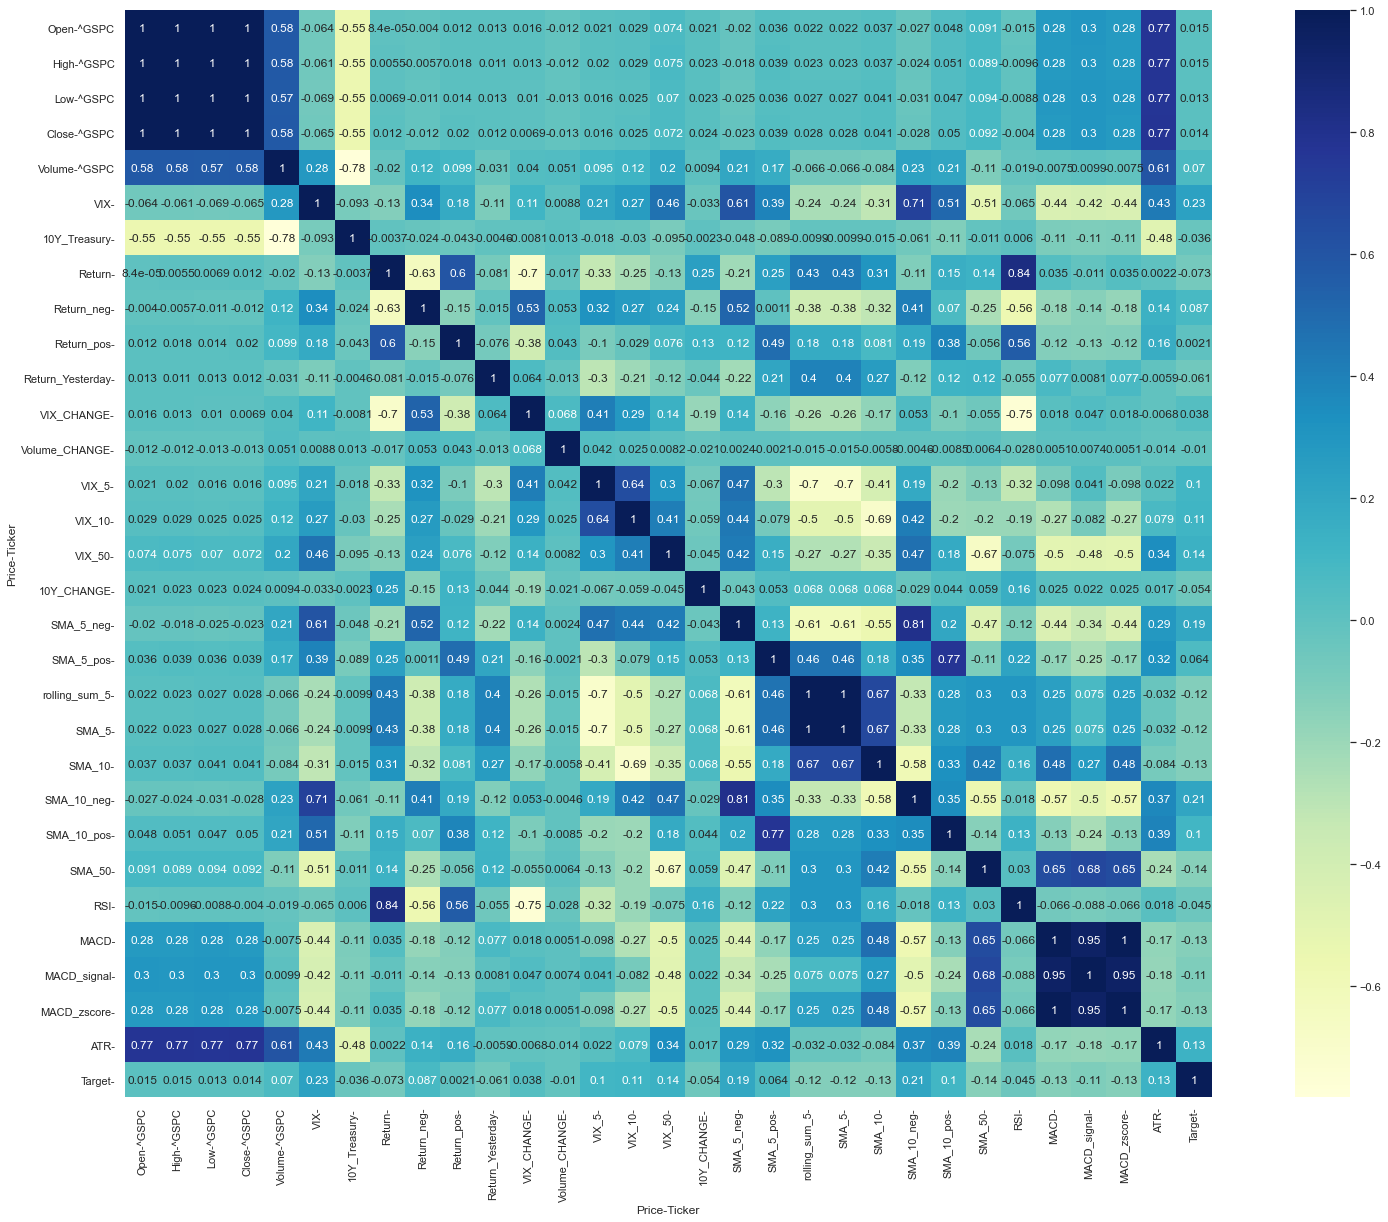

In [1128]:
corr_matrix = df.corr()
plt.figure(figsize=(30,20))
sns.set(font_scale=1)
sns.heatmap(corr_matrix, vmax=1, square=True, annot=True, cmap="YlGnBu")

In [1131]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
reduced_features = selector.fit_transform(df)
selected_features = df.columns[~selector.get_support()]
print("Selected Features:", selected_features)


Selected Features: MultiIndex([(          'Return', ''),
            (      'Return_neg', ''),
            ('Return_Yesterday', ''),
            (      'VIX_CHANGE', ''),
            (           'VIX_5', ''),
            (          'VIX_10', ''),
            (          'VIX_50', ''),
            (      '10Y_CHANGE', ''),
            (       'SMA_5_neg', ''),
            (   'rolling_sum_5', ''),
            (           'SMA_5', ''),
            (          'SMA_10', ''),
            (      'SMA_10_neg', ''),
            (          'SMA_50', '')],
           names=['Price', 'Ticker'])


In [1134]:
import pandas as pd

# Ensure all columns are displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

df


Price,Open,High,Low,Close,Volume,VIX,10Y_Treasury,Return,Return_neg,Return_pos,Return_Yesterday,VIX_CHANGE,Volume_CHANGE,VIX_5,VIX_10,VIX_50,10Y_CHANGE,SMA_5_neg,SMA_5_pos,rolling_sum_5,SMA_5,SMA_10,SMA_10_neg,SMA_10_pos,SMA_50,RSI,MACD,MACD_signal,MACD_zscore,ATR,Target
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,,,,,,,,,,,,,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1990-03-14,336.000000,337.630005,334.929993,336.869995,145060000,19.650000,8.650,0.002589,0.0,0.0,-0.007884,-0.066508,-0.002613,0.006573,-0.010220,0.004619,-0.009164,0.00,0.0,-0.000129,-0.000026,0.001514,2.775558e-18,0.1,-0.001270,50.698346,0.722494,-0.394130,-0.169283,3.723072,0
1990-03-15,336.869995,338.910004,336.869995,338.070007,144410000,18.809999,8.660,0.003562,0.0,0.0,0.002589,-0.042748,-0.004481,-0.008678,-0.014086,0.002662,0.001156,0.00,0.0,-0.006419,-0.001284,0.001614,2.775558e-18,0.1,-0.001147,51.036798,0.861298,-0.143045,-0.163081,3.602853,1
1990-03-16,338.070007,341.910004,338.070007,341.910004,222520000,17.620001,8.590,0.011359,0.0,1.0,0.003562,-0.063264,0.540891,-0.027004,-0.017855,0.000264,-0.008083,0.00,0.2,0.011816,0.002363,0.001908,2.775558e-18,0.2,-0.000748,53.775144,1.266557,0.138875,-0.144975,3.619792,0
1990-03-19,341.910004,343.760010,339.119995,343.529999,142300000,18.290001,8.590,0.004738,0.0,0.0,0.011359,0.038025,-0.360507,-0.017133,-0.017286,0.000098,0.000000,0.00,0.2,0.014364,0.002873,0.002919,2.775558e-18,0.2,-0.000458,51.158633,1.698864,0.450873,-0.125661,3.692665,0
1990-03-20,343.529999,344.489990,340.869995,341.570007,177320000,19.059999,8.540,-0.005705,0.0,0.0,0.004738,0.042099,0.246100,-0.018479,-0.006358,0.000791,-0.005821,0.00,0.2,0.016543,0.003309,0.001092,2.775558e-18,0.1,-0.000662,47.252841,1.861853,0.733069,-0.118378,3.687474,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-25,5982.729980,5992.649902,5908.490234,5955.250000,5374690000,19.430000,4.298,-0.004680,0.0,0.0,-0.004969,0.023709,0.077066,0.049831,0.022202,0.013261,-0.021625,0.02,0.0,-0.028670,-0.005734,-0.001826,1.000000e-02,0.1,-0.000227,48.298147,6.832571,22.724929,0.103704,64.317955,0
2025-02-26,5970.870117,6009.819824,5932.689941,5956.060059,4869580000,19.100000,4.249,0.000136,0.0,0.0,-0.004680,-0.016984,-0.093979,0.047477,0.019176,0.013768,-0.011401,0.02,0.0,-0.030911,-0.006182,-0.001846,1.000000e-02,0.1,-0.000388,50.531752,-0.984731,17.982997,-0.245559,65.233093,0


In [1026]:
X.iloc[-1]

Price       Ticker
Return                -0.017597
Return_neg             0.100000
Return_pos             0.000000
SMA_5_neg              0.040000
SMA_5_pos              0.200000
VIX                   22.780001
ATR                   81.125646
MACD                 -28.348137
RSI                   44.924687
Name: 2025-03-03 00:00:00, dtype: float64

In [1031]:
str(X.iloc[-1].name.date())

'2025-03-03'

In [1036]:
datetime.datetime.today().strftime('%Y-%m-%d')

'2025-03-04'